<font size="5">__cta-lstchain: Notebook for testing the effects of impact parameters on the energy reconstruction__</font>
    
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/misabelber/cta-lstchain-extra

**Content:**
- Definition of two functions for presenting the energy resolution:
    - plot_e_resolution: For plotting the STD and Bias of Erec-Etrue in several energy bins.
    - calc_resolution: For calculating the overall energy resolution in terms of the 68% area.
- Plotting energy vs. intensity to check linearity.
- Training RF without cuts in Impact Parameter.
- Taining RF only with events with Impact Parameter between 40 m and 100 m.
- Training RF witg all events, but including Impact Parameter as a feature.



<font size="4">
**Some imports...**

In [1]:
import numpy as np                                                                                            
import pandas as pd                                                                                                                                                                                      
import matplotlib.pyplot as plt                                                                                                                                                             
from lstchain.reco import reco_dl1_to_dl2     
from lstchain.visualization import plot_dl2                                                                   
from lstchain.reco import utils
import scipy
from matplotlib import gridspec 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14

<font size="4">
**Define two functions to show results later**

In [2]:
def plot_e_resolution(data,Nbins):
    plt.rcParams['figure.figsize'] = (30, 10)
    plt.rcParams['font.size'] = 14

    #difE = ((data['mc_energy']-data['e_rec'])*np.log(10))
    difE = np.log(10**data['e_rec']/10**data['mc_energy'])
    means_result = scipy.stats.binned_statistic(                                                                                                        
            data['mc_energy'],[difE,difE**2],                                                                                                             
            bins=Nbins,range=(1,6),statistic='mean')                                                                                                           
    means, means2 = means_result.statistic                                                                                                              
    standard_deviations = np.sqrt(means2 - means**2)                                                                                                    
    bin_edges = means_result.bin_edges                                                                                                                  
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    gs0 = gridspec.GridSpec(1,2,width_ratios=[1,2])
    subplot = plt.subplot(gs0[0])
    gs = gridspec.GridSpecFromSubplotSpec(2, 1,height_ratios=[1, 1],subplot_spec=subplot)

    ax0 = plt.subplot(gs[0])                                                                                                                            
    plot0 = ax0.errorbar(x=bin_centers, y=means, yerr=standard_deviations,linestyle='none', marker='.')

    plt.ylabel('Bias',fontsize=24)
    plt.grid()
    ax1 = plt.subplot(gs[1],sharex = ax0)                                                                                                              
    plot1 = ax1.plot(bin_centers,standard_deviations,                                                                                                   
                     marker='+',linestyle='None')
    plt.ylabel('STD',fontsize=24)
    plt.xlabel('$log_{10}E_{true}(GeV)$',fontsize=24)
    plt.grid()

    subplot2 = plt.subplot(gs0[1])
    
    #Lines for setting the configuration of the subplots depending on Nbins
    import math
    sqrtNbins = np.sqrt(Nbins)
    a = int(math.ceil(sqrtNbins))
    dif = a - sqrtNbins
    b=a
    if dif > 0.5:
        b=a-1
        
    gs2 = gridspec.GridSpecFromSubplotSpec(a, b,subplot_spec=subplot2)
    for nbin in range(0,Nbins):
        ax = plt.subplot(gs2[nbin])
        plt.hist(difE[means_result.binnumber==nbin+1],50,label='$logE_{center}$ '+'%.2f' % bin_centers[nbin])
        plt.legend()
    plt.subplots_adjust(hspace=.25)
    plt.subplots_adjust(wspace=.5)

In [3]:
def calc_resolution(data):
    difE = np.log(10**data['e_rec']/10**data['mc_energy'])
    n , bins, _ = plt.hist(difE,bins=500)
    mu,sigma = scipy.stats.norm.fit(difE)
    print(mu,sigma)
    bin_width = bins[1] - bins[0]
    total = bin_width*sum(n)*0.68
    idx = np.abs(bins - mu).argmin()
    x = 0
    mindif = 1e10
    xpos=0
    integral=0
    while integral <= total: 
        integral = bin_width*sum(n[idx-x:idx+x])
        x = x+1
    print(x,integral,total)
    sigma = bins[idx+x-1]
    plt.plot(bins,integral*scipy.stats.norm.pdf(bins, mu, sigma),linewidth=4,color='red',linestyle='--')
    plt.xlabel("$log(E_{rec}/E_{true})$")
    print(mu,sigma)
    return mu,sigma

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<font size="4">
**Get event DL1 file for training.**
<br>
Gammas are pointlike.

In [5]:
try:
    PATH_EVENTS = "/home/queenmab/DATA/LST1/Events"
    gammafile = PATH_EVENTS+"/gamma_events_point.h5"
    df_gammas = pd.read_hdf(gammafile) 
    
except:
    PATH_EVENTS = "../../cta-lstchain-extra/reco/sample_data/dl1/"
    gammafile = PATH_EVENTS+"/gamma_events_point_tiny.h5"
    df_gammas = pd.read_hdf(gammafile) 

<font size="4">
We read the file as pandas dataframes:

In [6]:
df_gammas.keys()

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'wl', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness'],
      dtype='object')

<font size="4">
We can keep only bright showers:

In [7]:
df_gammas = df_gammas[df_gammas['intensity']>np.log10(300)]
df_gammas.describe()

,obs_id,event_id,mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,gps_time,...,mc_alt_tel,mc_az_tel,impact,mc_x_max,time_gradient,intercept,src_x,src_y,disp,hadroness
count,121810.000000,1.218100e+05,121810.000000,121810.00000,121810.000000,121810.000000,121810.000000,121810.000000,121810.0,1.218100e+05,...,121810.00000,121810.0,121810.000000,121810.000000,121810.000000,121810.000000,1.218100e+05,1.218100e+05,121810.000000,121810.0
mean,11030.064740,5.000500e+06,2.558007,1.22173,6.283185,-89.019809,-7.773842,25108.073161,0.0,1.445304e+09,...,1.22173,0.0,187.085380,284.780543,-0.036436,8.014762,4.103384e-13,-2.892042e-06,0.565852,0.0
std,657.733032,2.889776e+06,0.573633,0.00000,0.000000,140.030741,152.321708,8323.509569,0.0,1.215790e+05,...,0.00000,0.0,90.384937,67.084637,11.041849,3.677542,2.019492e-28,1.270555e-21,0.238050,0.0
min,10147.000000,3.030000e+02,0.837788,1.22173,6.283185,-1134.100586,-599.204346,5730.250000,0.0,1.445077e+09,...,1.22173,0.0,0.378799,-20.000000,-75.114238,-34.812236,4.103384e-13,-2.892042e-06,0.003186,0.0
25%,10386.000000,2.493703e+06,2.139048,1.22173,6.283185,-190.212273,-114.304245,19374.996582,0.0,1.445191e+09,...,1.22173,0.0,119.994959,238.768322,-7.149829,6.453567,4.103384e-13,-2.892042e-06,0.373127,0.0
50%,11495.000000,4.998758e+06,2.457045,1.22173,6.283185,-89.630074,-8.003608,23638.800781,0.0,1.445334e+09,...,1.22173,0.0,174.980100,277.500000,-0.040279,9.064687,4.103384e-13,-2.892042e-06,0.547137,0.0
75%,11680.000000,7.500252e+06,2.868242,1.22173,6.283185,11.036971,99.007421,29148.908203,0.0,1.445409e+09,...,1.22173,0.0,247.097679,321.559631,7.051422,10.487890,4.103384e-13,-2.892042e-06,0.770790,0.0
max,11715.000000,1.000001e+07,5.488329,1.22173,6.283185,724.754822,752.423767,102674.273438,0.0,1.445554e+09,...,1.22173,0.0,1081.033976,775.039368,82.991954,23.041262,4.103384e-13,-2.892042e-06,1.123339,0.0


<font size="4">
Energy should be proportional to intensity:

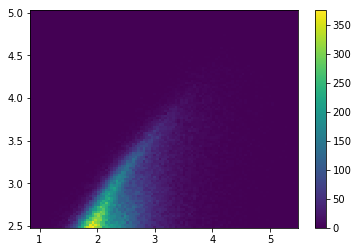

In [8]:
h = plt.hist2d(df_gammas['mc_energy'],df_gammas['intensity'],bins=100)
plt.colorbar(h[3])

<font size="4">
Let's choose events with a closer impact parameter (>40m, <100m)

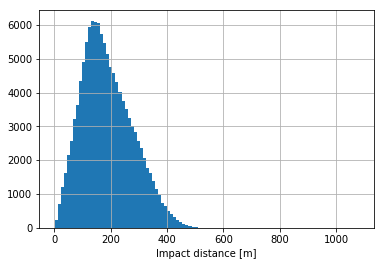

In [9]:
#df_gammas['mc_core_distance'] = df_gammas['impact'] #Uncomment if you are using an old file without the "mc_core_distance key"
df_gammas.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

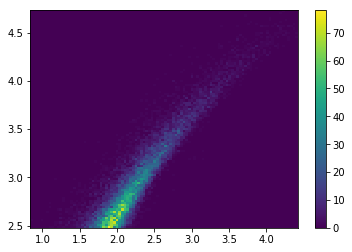

In [12]:
filter_impact = (df_gammas.mc_core_distance > 40) & (df_gammas.mc_core_distance < 100)
closer = df_gammas[filter_impact]
c = plt.hist2d(closer['mc_energy'],closer['intensity'],bins=100)
plt.colorbar(c[3]);

<font size="4">
Correlation is much more clear for this range. 
<br><br>
Let's see how this cut affect to the energy reconstruction.
<br><br>
First of all, let's train a Random Forest with all events, **without any cut** and without using any mc information.
<br>
Choose the features for training the random forest (Hillas and Timing parameters) 

In [13]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis']

<font size="4">
Split data into train and test sets.

In [14]:
np.random.seed(0)
train, test = reco_dl1_to_dl2.split_traintest(df_gammas, 0.8)
print("Training datasets: {} events \nTest dataset: {} events".format(len(train), len(test)))

Training datasets: 97347 events 
Test dataset: 24463 events


<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [15]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  97347
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


<font size="4">
Apply RF to test data to reconstruct Energy.

Feature importances (gini index)
1. intensity (0.444094)
2. skewness (0.275582)
3. time_gradient (0.146092)
4. length (0.073646)
5. kurtosis (0.024011)
6. wl (0.015892)
7. width (0.010838)
8. psi (0.007609)
9. phi (0.002237)


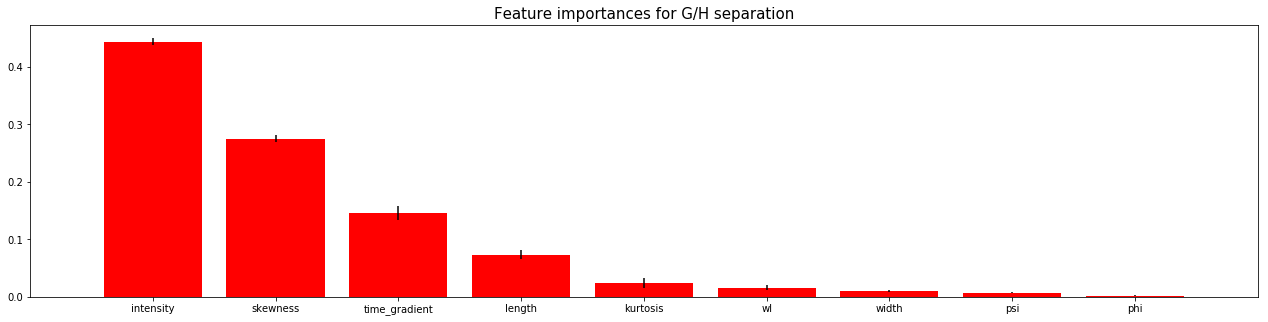

In [16]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

In [17]:
test['e_rec'] = RFreg_Energy.predict(test[features])

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0009204079070037636 0.5865754779945535
20 396.9236485359748 386.4654015576339
0.0009204079070037636 0.4482442770658768


(0.0009204079070037636, 0.4482442770658768)

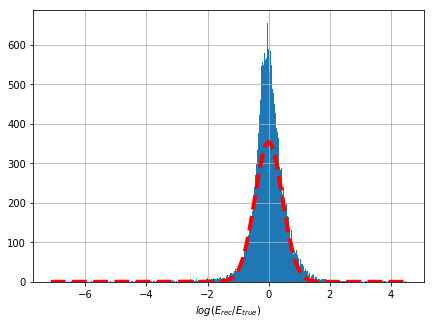

In [18]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test,True)
calc_resolution(test)

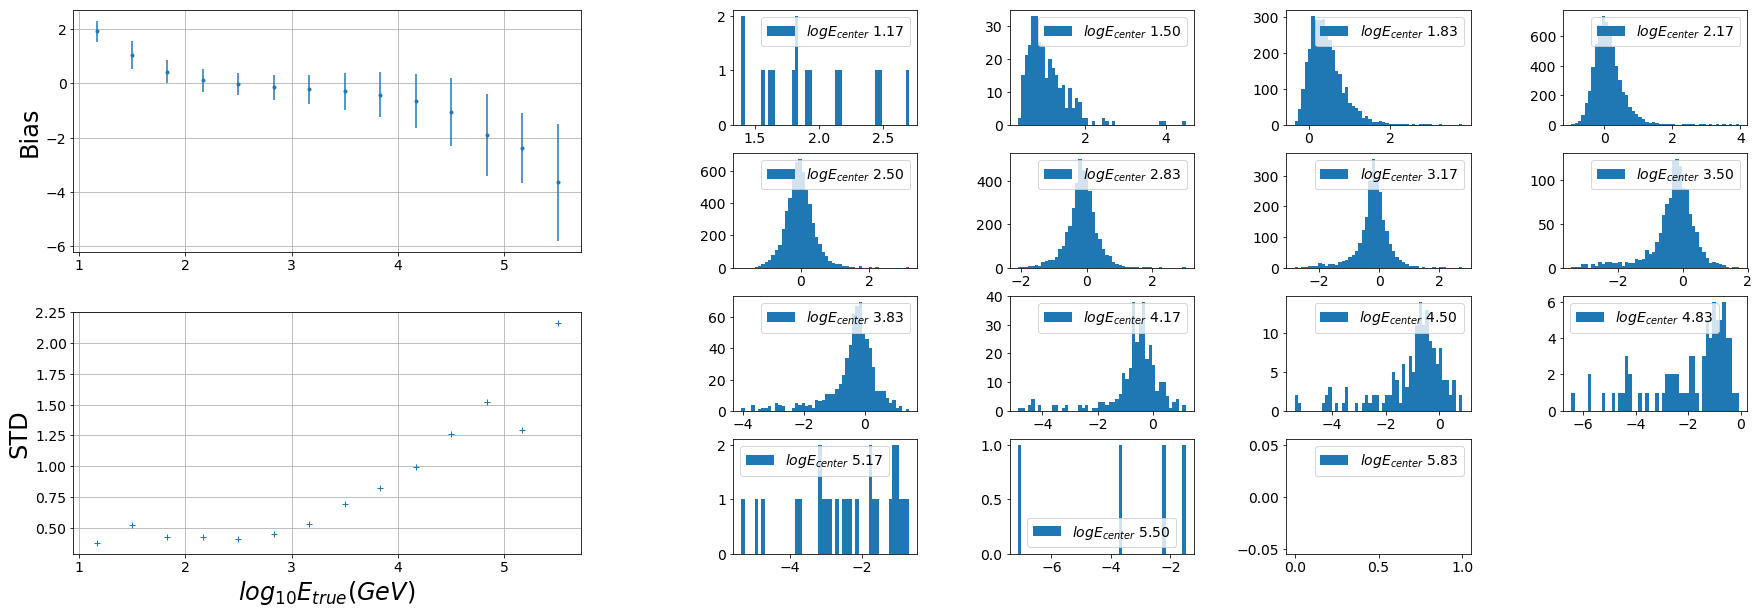

In [19]:
plot_e_resolution(test,15)

<font size="4">
    Now, lets do the cuts on impact parameter to have closer events.

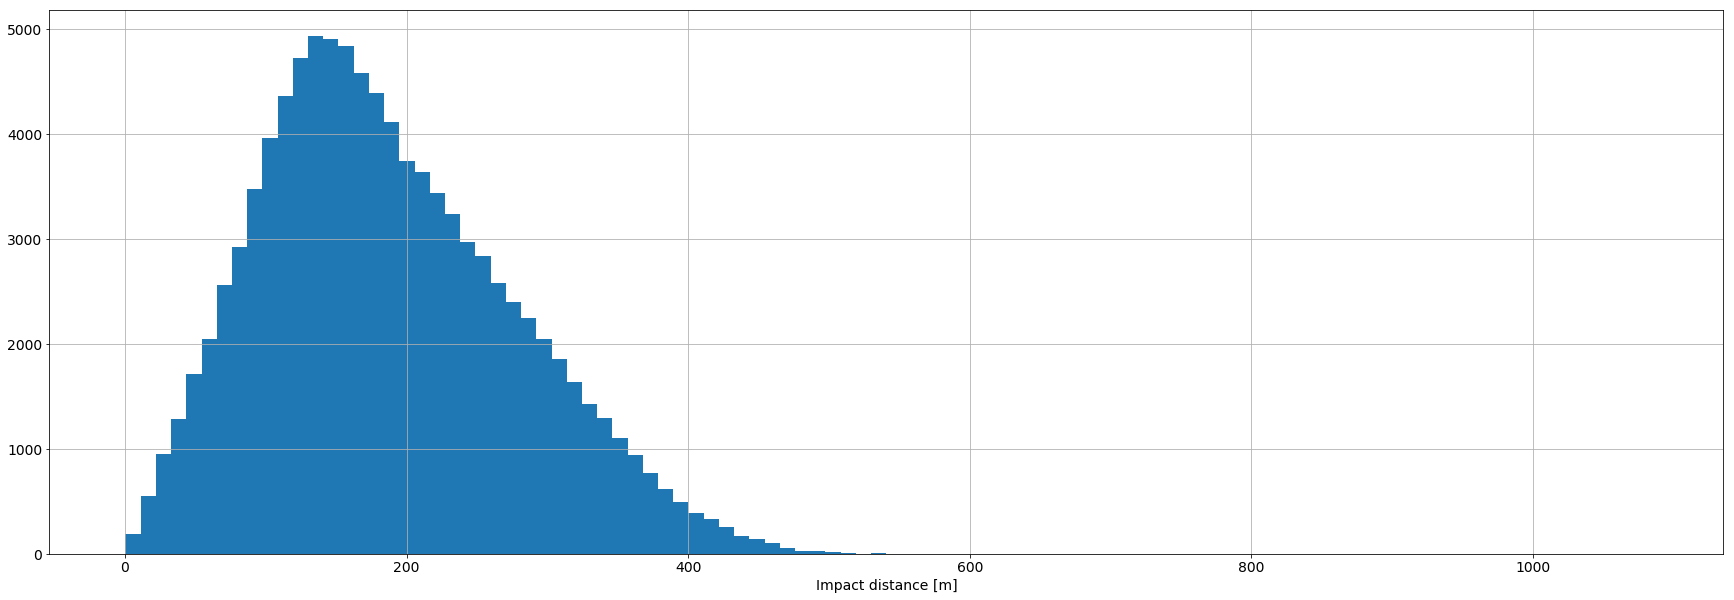

In [20]:
train.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

In [21]:
train_cut = train[(train.mc_core_distance>40) & (train.mc_core_distance<200)]
test_cut = test[(test.mc_core_distance>40) & (test.mc_core_distance<200)]

<font size="4">
    Train the RF again.

In [22]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train_cut, features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  55829
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.945336)
2. time_gradient (0.019685)
3. skewness (0.011277)
4. psi (0.005114)
5. length (0.004231)
6. phi (0.004141)
7. width (0.003627)
8. wl (0.003295)
9. kurtosis (0.003294)


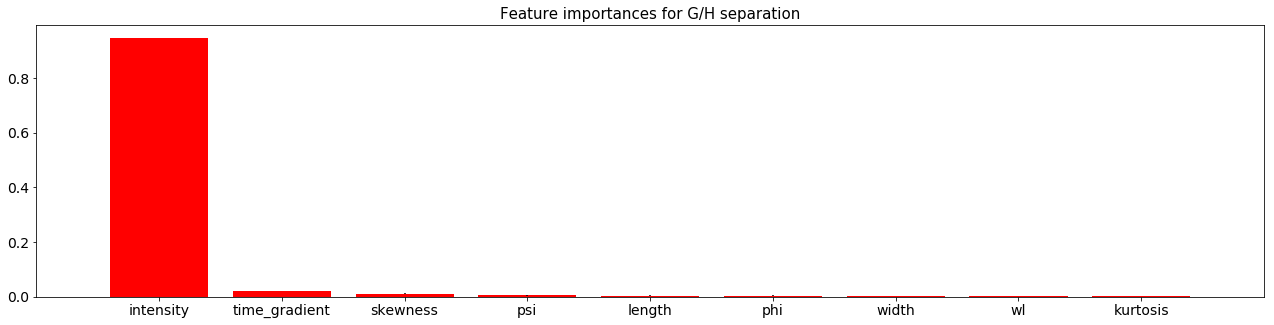

In [23]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
    And reconstruct the energy.

In [24]:
test_cut['e_rec'] = RFreg_Energy.predict(test_cut[features])

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.004021033403316867 0.3570731843701014
37 85.25930545771887 84.8535398096558
0.004021033403316867 0.32326490090952653


(0.004021033403316867, 0.32326490090952653)

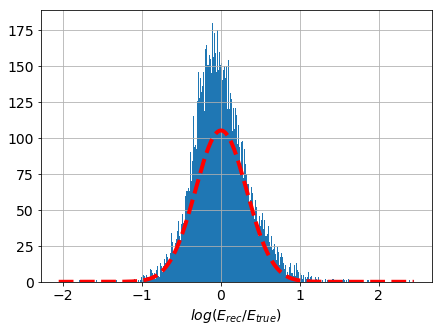

In [25]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test_cut,True)
calc_resolution(test_cut)

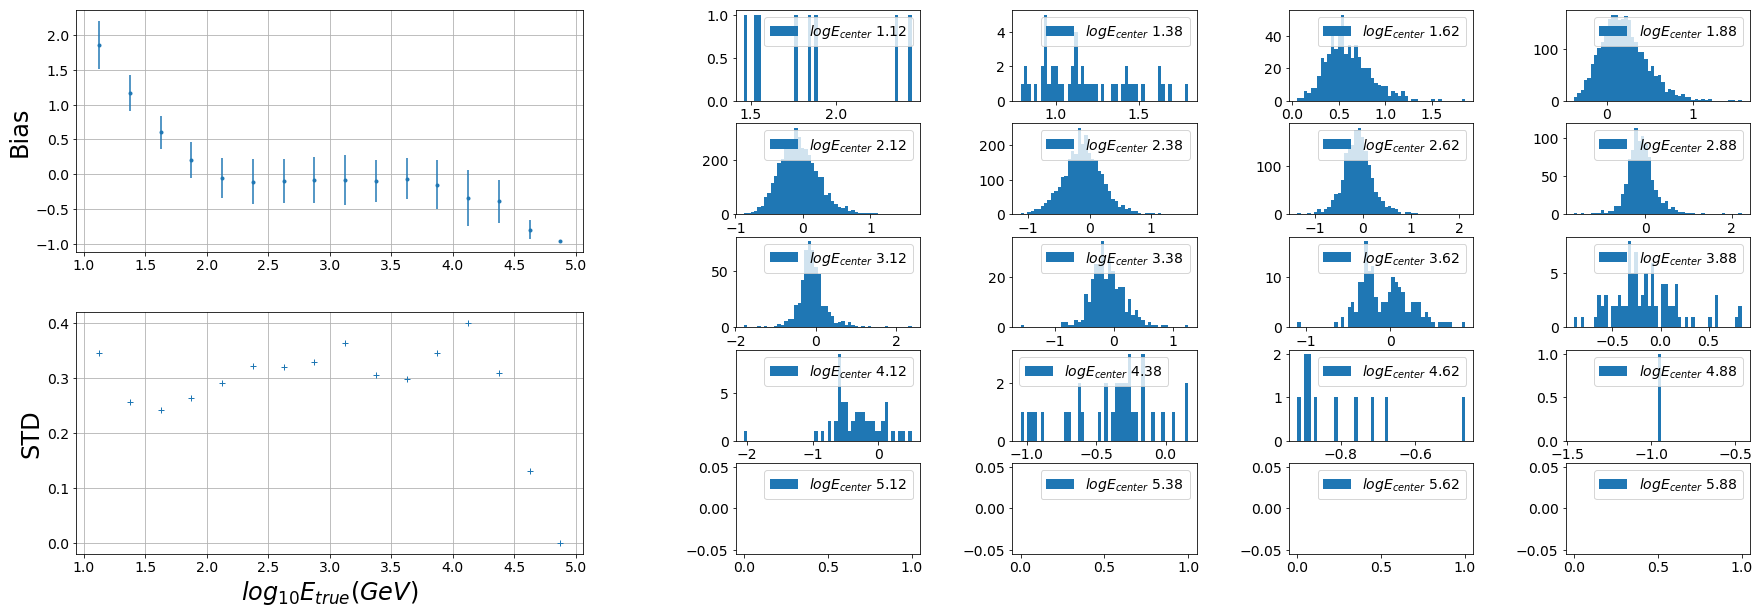

In [26]:
plot_e_resolution(test_cut,20)

<font size="4">
    Let's do a last test. We will use all events, but using the impact parameter as a feature.

In [27]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis',
            'mc_core_distance']

<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [28]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis', 'mc_core_distance']
Number of events for training:  97347
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.494541)
2. mc_core_distance (0.435954)
3. skewness (0.029071)
4. wl (0.015471)
5. length (0.012974)
6. phi (0.006897)
7. psi (0.002597)
8. kurtosis (0.001530)
9. width (0.000563)
10. time_gradient (0.000403)


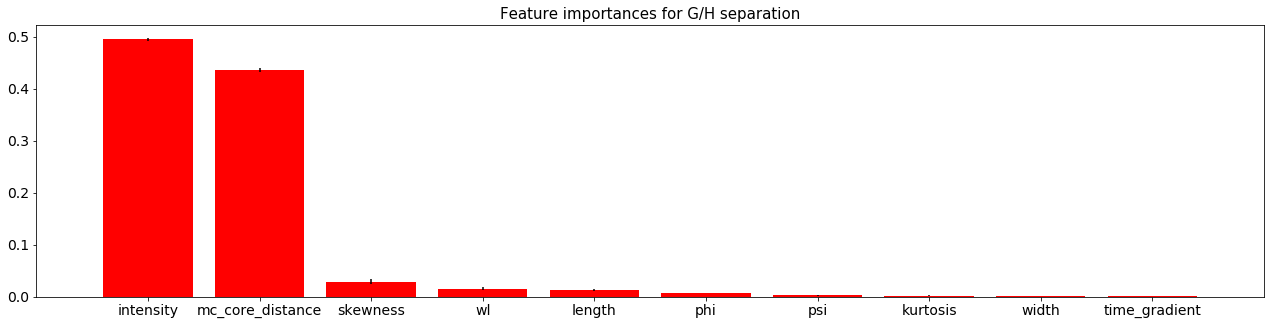

In [29]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
Apply RF to test data to reconstruct Energy.

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.002002884566502293 0.33701943882644464
15 312.9751721160718 309.9352251531918
0.002002884566502293 0.25606945582489793


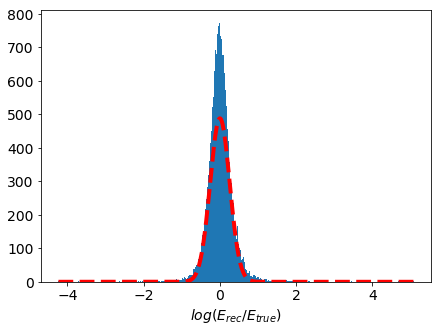

In [30]:
test['e_rec'] = RFreg_Energy.predict(test[features])
plt.figure(figsize=(7,5))
#plot_dl2.plot_e(test,True)
calc_resolution(test)
plt.savefig("gaussian_fit.png")

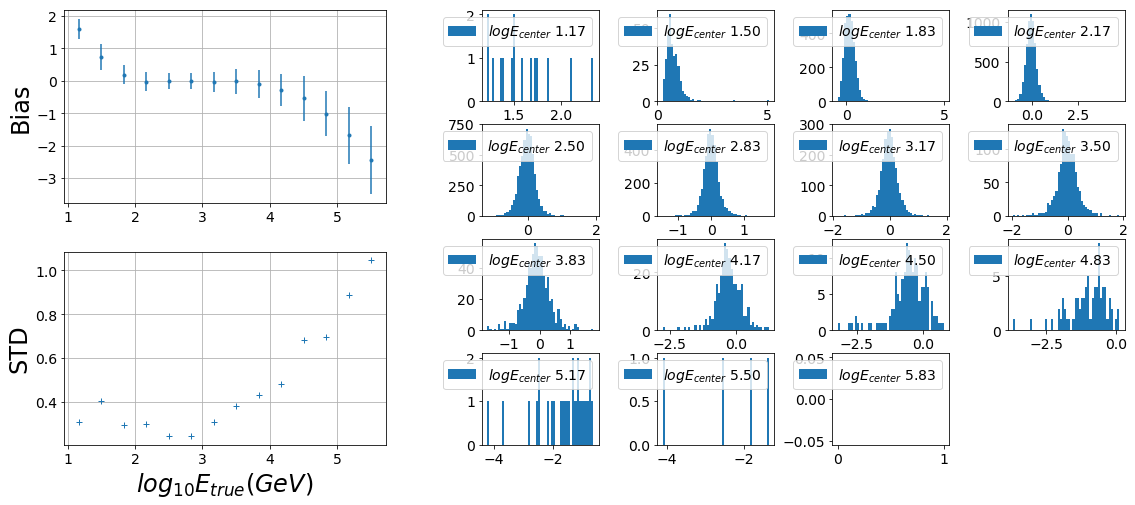

In [32]:
plt.figure(figsize=(19,8))
plot_e_resolution(test,15)